# GHCN Analysis

In [1]:
import os
from glob import glob

import dask
import dask.bag as db
import dask.dataframe as dd

import pandas as pd

from distributed import Client
from dask_jobqueue import SLURMCluster

from IPython.display import display
import matplotlib.pyplot as plt

from ghcn import load_daily

In [2]:
# Set LOCAL to True for single-machine execution while developing
# Set LOCAL to False for cluster execution
LOCAL = True

if LOCAL:
    # This line creates a single-machine dask client
    client = Client()
else:    
    # This line creates a SLURM cluster dask and dask client
    # Logging outputs will be stored in /scratch/{your-netid}
    
    cluster = SLURMCluster(
                           # Memory and core limits should be sufficient here
                           memory='4GB', cores=2,

                           # Ensure that Dask uses the correct version of Python on the cluster
                           python='/scratch/work/public/dask/{}/bin/python'.format(dask.__version__),                           
                           
                           # Place the output logs in an accessible location
                           job_extra=['--output=/scratch/{}/slurm-%j.out'.format(os.environ['SLURM_JOB_USER'])]
    )

    cluster.submit_command = 'slurm'
    cluster.scale(50)

    display(cluster)
    client = Client(cluster)

display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 6,Total memory: 15.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50251,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 15.37 GiB
Comm: tcp://127.0.0.1:50274,Total threads: 2
Dashboard: http://127.0.0.1:50277/status,Memory: 5.12 GiB
Nanny: tcp://127.0.0.1:50254,


In [3]:
# Get a list of all input files
# We'll sort them alphabetically to ensure reproducibility

files = sorted(glob('ghcnd_gsn/ghcnd_gsn/*.dly'))
#files = sorted(glob('/scratch/work/courses/DSGA1004-2021/ghcnd_small/*.dly'))
#files = sorted(glob('/scratch/work/courses/DSGA1004-2021/ghcnd_all/*.dly'))

# Load in a single file to demonstrate the parser
# Just print out the first few records to illustrate the structure
load_daily(files[0])[:3]

[{'station_id': 'AE000041196',
  'year': 1944,
  'month': 3,
  'element': 'TMAX',
  'day': 1,
  'value': -9999,
  'measurement': ' ',
  'quality': ' ',
  'source': ' '},
 {'station_id': 'AE000041196',
  'year': 1944,
  'month': 3,
  'element': 'TMAX',
  'day': 2,
  'value': -9999,
  'measurement': ' ',
  'quality': ' ',
  'source': ' '},
 {'station_id': 'AE000041196',
  'year': 1944,
  'month': 3,
  'element': 'TMAX',
  'day': 3,
  'value': -9999,
  'measurement': ' ',
  'quality': ' ',
  'source': ' '}]

In [106]:
# Load daily files into bags
from dask import delayed
L = []
for i in range(3):
    data = delayed(load_daily)(files[i])
    L.append(data)

ddf = delayed(db.from_sequence)(L)
%time ddf.compute()
# ...

CPU times: total: 93.8 ms
Wall time: 20.3 s


dask.bag<from_sequence, npartitions=3>

In [111]:
# Compute aggregated statistics
dict_df = load_daily(files[i])
for i in range(1,5):
    dt = load_daily(files[i])
    dict_df = dict_df + dt

df = pd.DataFrame(dict_df)
ddf = dd.from_pandas(df,npartitions=3)
# ...

,station_id,year,month,element,day,value,measurement,quality,source
0,AG000060611,1958,10,TMAX,1,363,,,G
1,AG000060611,1958,10,TMAX,2,383,,,G
2,AG000060611,1958,10,TMAX,3,383,,,G
3,AG000060611,1958,10,TMAX,4,383,,,G
4,AG000060611,1958,10,TMAX,5,375,,,G
...,...,...,...,...,...,...,...,...,...
441807,AG000060611,2024,5,TAVG,27,-9999,,,
441808,AG000060611,2024,5,TAVG,28,-9999,,,
441809,AG000060611,2024,5,TAVG,29,-9999,,,
441810,AG000060611,2024,5,TAVG,30,-9999,,,


In [131]:

%time
df_tmin = df.loc[df.element=='TMIN',['station_id','year','month','day','value']]
df_tmin.columns = ['station_id','year','month','day','TMIN']
df_tmax = df.loc[df.element=='TMAX',['station_id','year','month','day','value']]
df_tmax.columns = ['station_id','year','month','day','TMAX']
caculat_df = df_tmin.merge(df_tmax)
caculat_df['t_range'] = caculat_df['TMAX']-caculat_df['TMIN']
res_df = caculat_df[['station_id','TMAX','TMIN','t_range']]
res_df.head()

CPU times: total: 0 ns
Wall time: 0 ns


,station_id,TMAX,TMIN,t_range
0,AG000060611,363,189,174
1,AG000060611,363,189,174
2,AG000060611,363,189,174
3,AG000060611,363,189,174
4,AG000060611,383,166,217


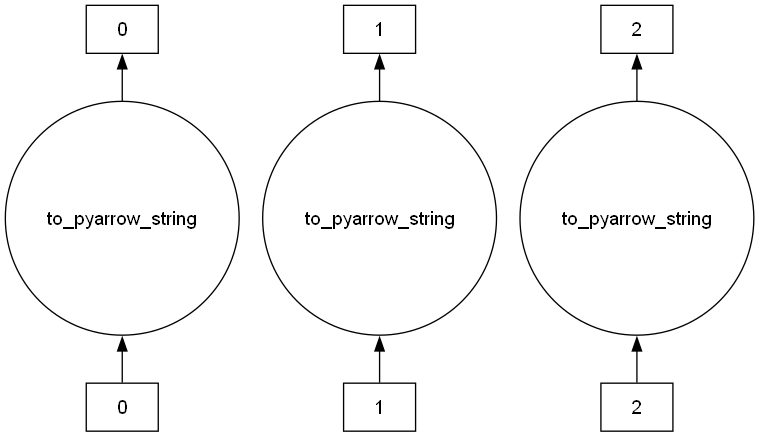

In [132]:
# Plot the results
ddf.visualize()
# ...